# Cube slicing
- Demonstrate how to slice n-dimensional data cubes in to 1d-cubes.
- Show how to convert WGS84 latitude, longitude coordinates into other coordinate systems

## Cube slicing with `xarray`

### Read data
Read data from S3 bucket

In [1]:
import s3fs
import xarray as xr
import rioxarray as rxr
from configparser import ConfigParser
import os
def config(filename, section='s3'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
    # get section, default to postgresql
    s3 = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            s3[param[0]] = param[1]
    else:
        raise KeyError(
            f'Section {section} not found in {filename}. Did you specifiy the right path?')
    return s3


try:
    s3_config = config('../../database.ini')
   
except KeyError as er:
    print(er)
    print('Config file not found or malformed, trying with environment variables...')
    if (os.environ.get('S3_FAIRICUBE_STORAGE_BUCKET') is None):
        print('environment variables not set, contact the admin')
    else:
        s3_config = {
            's3_fairicube_storage_bucket': os.environ.get('S3_FAIRICUBE_STORAGE_BUCKET'),
            's3_fairicube_storage_key': os.environ.get('S3_FAIRICUBE_STORAGE_KEY'),
            's3_fairicube_storage_secret': os.environ.get('S3_FAIRICUBE_STORAGE_SECRET')}
        
s3fs_FS = s3fs.S3FileSystem(
    key=s3_config['s3_fairicube_storage_key'],
    secret=s3_config['s3_fairicube_storage_secret'],
)

In [2]:
# land use
import pandas as pd
da = rxr.open_rasterio(s3fs_FS.open('s3://fairicube/vienna_data/100m/r01_landuse/r01_real_land_use2020_100m_b32_1_1.tif'))
# convert bands into data variables
ds_landuse = xr.merge([da[band].to_dataset(name=f'land_use{band+1}') for band in range(0,32)], compat='override')
ds_landuse

<xarray.Dataset>
Dimensions:      (x: 300, y: 230)
Coordinates:
    band         int32 1
  * x            (x) float64 -1.115e+04 -1.105e+04 ... 1.865e+04 1.875e+04
  * y            (y) float64 3.54e+05 3.538e+05 3.538e+05 ... 3.312e+05 3.31e+05
    spatial_ref  int32 0
Data variables: (12/32)
    land_use1    (y, x) float32 ...
    land_use2    (y, x) float32 ...
    land_use3    (y, x) float32 ...
    land_use4    (y, x) float32 ...
    land_use5    (y, x) float32 ...
    land_use6    (y, x) float32 ...
    ...           ...
    land_use27   (y, x) float32 ...
    land_use28   (y, x) float32 ...
    land_use29   (y, x) float32 ...
    land_use30   (y, x) float32 ...
    land_use31   (y, x) float32 ...
    land_use32   (y, x) float32 ...

Check the `coordinates` of the data cube: `xarray` uses the coordinates of the center point of cell. The extent of the dataset is
```
x_min = -11200.0, 
x_max = 18800.0,
y_min = 331000.0,
y_max = 354000.0
```
with a resolution of `100m`. Therefore the coordinate of the lower-left cell is `(x_min+50,y_min+50) = (-11150.0, 331050.0)` and so on

### Slice cube given point coordinates in WGS84
Let's select a point in OpenStreetMap. OSM uses WGS84, so the coordinates of the point are given in latitude and longitude. In the next cell we convert  the coordinates in the Austrian coordinate reference system, EPSG:31256 using the library `pyproj`.

![2024-07-23 09_13_17-OpenStreetMap.png](<attachment:2024-07-23 09_13_17-OpenStreetMap.png>)
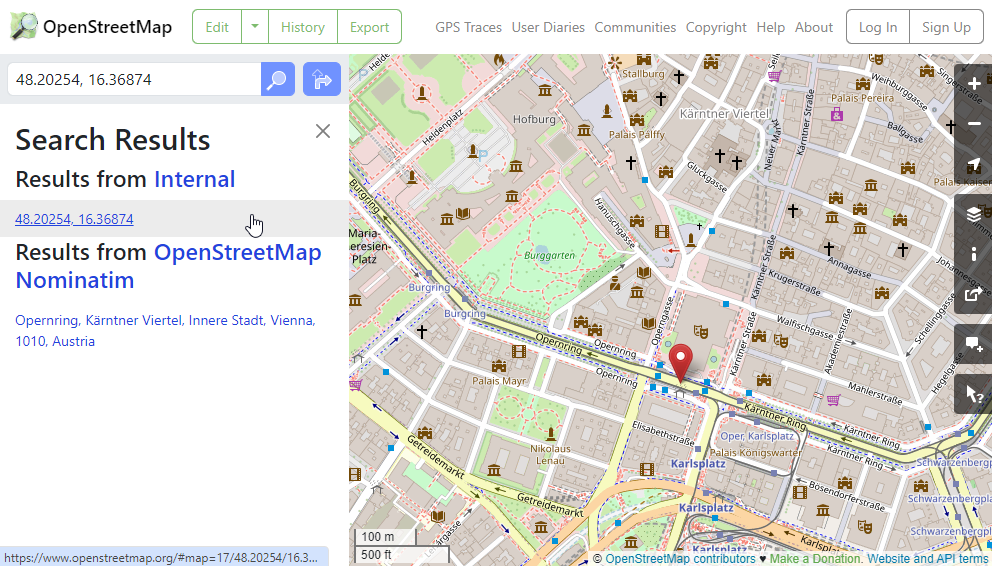

In [24]:
# convert WGS84 lat, long coordinates in EPSG:31256 (Austrian projection)
import pyproj
lat,long = 48.20254, 16.36874

transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:31256", always_xy=True)

# Perform the transformation
x, y = transformer.transform(long, lat)
print(f"Coordinates in WGS84 (EPSG:4326): lat={lat}, long={long}")
print(f"Coordinates in EPSG:31256: x={x}, y={y}")

Coordinates in WGS84 (EPSG:4326): lat=48.20254, long=16.36874
Coordinates in EPSG:31256: x=2720.9872397864074, y=340459.83491985966


Now we use the transformed `x,y` coordinates to query the data cube.`x,y` will not exactly match any of the coordinates of our data cube, but we can tell `xarray` how to handle them. In this case, we want to find the nearest cell, that is, the cell in which `x,y` falls in.

Alternatively, we can compute the coordinates of the cell with some math.

In [46]:
# look for the nearest coordinates in the cube
cube_1d = ds_landuse.sel(x=x, y=y, method='nearest')
print(cube_1d.coords)

# this is the same as
x_cell = (x//100)*100 + 50 # round up to the closest hundred and offset by 50m
y_cell = (y//100)*100 + 50 
print(x_cell,y_cell)


Coordinates:
    band         int32 1
    x            float64 2.75e+03
    y            float64 3.404e+05
    spatial_ref  int32 0
2750.0 340450.0


Let's check in QGIS that we hit the right cell in the cube: yes! Let's also check that the values of the cube at this cell are the expected ones. Looking at the base map, we see that the cell is mostly covered by a road, and partly by buildings.

![2024-07-23 09_43_01-ALBEDO - Remote Desktop Connection.png](<attachment:2024-07-23 09_43_01-ALBEDO - Remote Desktop Connection.png>)
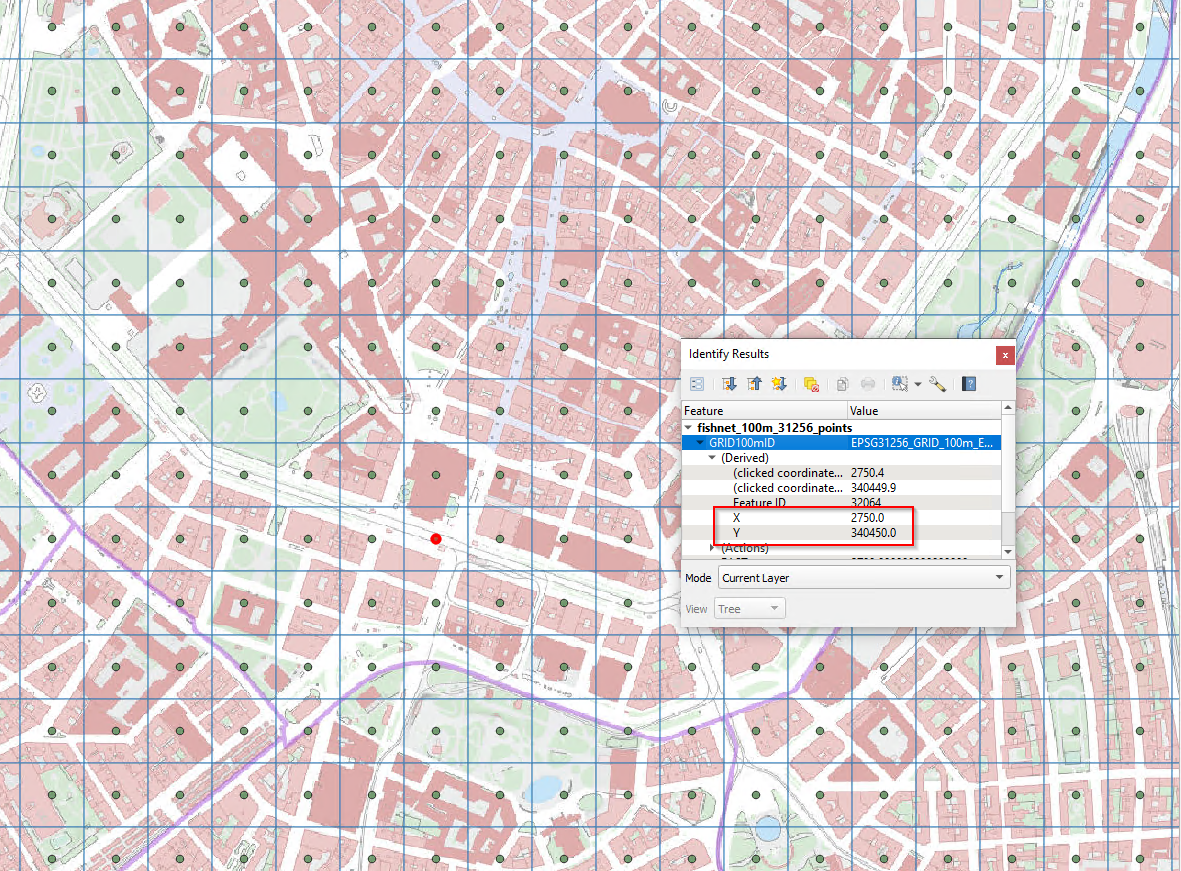

In [68]:
# load land use lookup table and rename the data variables to meaningful names
# read LookUpTable (lut)
lut_land_use =pd.read_csv(s3fs_FS.open('s3://fairicube/vienna_data/100m/r01_landuse/lut_realnutzung.csv'))

#update Data variables
variable_list = list(cube_1d.keys()) 

for variable_in_list in variable_list:
    cell_value=lut_land_use[lut_land_use['NUTZUNG_CODE'] == int(variable_in_list[8:])]['NUTZUNG_L1'].values[0]
    cube_1d=cube_1d.rename(name_dict={variable_in_list:cell_value})

In [73]:
# what are the land use classes?
lut_land_use

,NUTZUNG_CODE,NUTZUNG_TEXT,NUTZUNG_L0,NUTZUNG_L1,FLY_indiciator
0,1,Baulandnutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),locker bebautes Wohn(misch)gebiet,2
1,2,Baulandnutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),Wohn(misch)gebiet mittlerer Dichte,1
2,3,Baulandnutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),dichtes Wohn(misch)gebiet,1
3,4,Baulandnutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),"grossvolumiger, solidaerer Wohn(misch)bau",1
4,5,Baulandnutzung,"Geschaefts,- Kern- und Mischnutzung (Schwerpun...",Buero- und Verwaltungsviertel,1
5,6,Baulandnutzung,"Geschaefts,- Kern- und Mischnutzung (Schwerpun...",solitaere Handelsstrukturen,1
6,7,Baulandnutzung,"Geschaefts,- Kern- und Mischnutzung (Schwerpun...","Geschaefts-, Kern- u. Mischgebiete",1
7,8,Baulandnutzung,"Geschaefts,- Kern- und Mischnutzung (Schwerpun...",Mischnutzung wenig dicht,1
8,9,Baulandnutzung,Industrie- und Gewerbenutzung,"Industrie, prod. Gewerbe, Grosshandel inkl. Lager",0
9,10,Baulandnutzung,soziale Infrastruktur,"Kultur, Freizeit, Messe",1


In [81]:
# Check values for selected land use classes
print(f"Share of road: {cube_1d['Strassenraum unbegruent'].values}")
print(f"Share of administrative buildings: {cube_1d['Buero- und Verwaltungsviertel'].values}")

Share of road: 75.0
Share of administrative buildings: 13.0


## Cube slicing with SentinelHub
TODO